In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'n_iter', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_n_iter', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [5]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [6]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


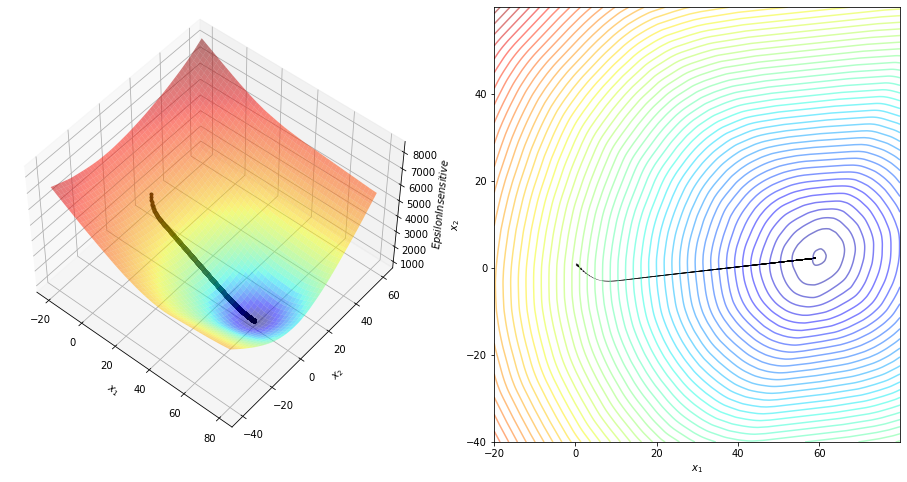

In [7]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, learning_rate=1, 
                              max_iter=4000, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_eps_loss.png')

In [8]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver  C   epsilon                                                     
adagrad 1   0.1      0.483018     873  0.919206  0.915684          66   
            0.2      0.501837     897  0.919990  0.916504          66   
            0.3      0.498535     880  0.920085  0.916655          65   
        10  0.1      2.049033    3542  0.977834  0.972868          65   
            0.2      1.913584    3511  0.977801  0.972839          65   
            0.3      1.882657    3478  0.977783  0.972878          65   
        100 0.1      2.263548    4000  0.978120  0.974239          66   
            0.2      2.248653    4000  0.978118  0.974263          66   
            0.3      1.818380    4000  0.978120  0.974189          66   

                     val_n_sv  
solver  C   epsilon            
adagrad 1   0.1            33  
            0.2            33  
            0.3            33  
        10  0.1            32  
            0.2            32  
            0.3            32  
        100 0.1            32  
            0.2            32  
            0.3            32

In [9]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [10]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver    C   epsilon                                                     
liblinear 1   0.1      0.000683      14  0.918827  0.916841          66   
              0.2      0.000565      12  0.918820  0.916672          65   
              0.3      0.000755      11  0.919212  0.916977          65   
          10  0.1      0.000760     103  0.977852  0.972051          65   
              0.2      0.000651     188  0.977844  0.971971          65   
              0.3      0.000603     105  0.977865  0.972111          64   
          100 0.1      0.000908     719  0.977723  0.974270          66   
              0.2      0.001058     689  0.977628  0.973889          65   
              0.3      0.001008     807  0.977658  0.974038          65   

                       val_n_sv  
solver    C   epsilon            
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

In [11]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='h!')
primal_svr_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver    C   epsilon                                                     
adagrad   1   0.1      0.483018     873  0.919206  0.915684          66   
              0.2      0.501837     897  0.919990  0.916504          66   
              0.3      0.498535     880  0.920085  0.916655          65   
          10  0.1      2.049033    3542  0.977834  0.972868          65   
              0.2      1.913584    3511  0.977801  0.972839          65   
              0.3      1.882657    3478  0.977783  0.972878          65   
          100 0.1      2.263548    4000  0.978120  0.974239          66   
              0.2      2.248653    4000  0.978118  0.974263          66   
              0.3      1.818380    4000  0.978120  0.974189          66   
liblinear 1   0.1      0.000683      14  0.918827  0.916841          66   
              0.2      0.000565      12  0.918820  0.916672          65   
              0.3      0.000755      11  0.919212  0.916977          65   
          10  0.1      0.000760     103  0.977852  0.972051          65   
              0.2      0.000651     188  0.977844  0.971971          65   
              0.3      0.000603     105  0.977865  0.972111          64   
          100 0.1      0.000908     719  0.977723  0.974270          66   
              0.2      0.001058     689  0.977628  0.973889          65   
              0.3      0.001008     807  0.977658  0.974038          65   

                       val_n_sv  
solver    C   epsilon            
adagrad   1   0.1            33  
              0.2            33  
              0.3            33  
          10  0.1            32  
              0.2            32  
              0.3            32  
          100 0.1            32  
              0.2            32  
              0.3            32  
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

### Dual formulations

In [12]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_nonlinearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [13]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [14]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1, 
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 18 candidates, totalling 54 fits
     pcost       dcost       gap    pres   dres
 0: -9.4975e+03 -2.8399e+05  3e+05  3e-13  3e-15
 1: -4.7740e+04 -9.4352e+04  5e+04  9e-13  4e-15
 2: -7.0202e+04 -7.7261e+04  7e+03  9e-13  4e-15
 3: -7.4090e+04 -7.5044e+04  1e+03  7e-13  5e-15
 4: -7.4443e+04 -7.4808e+04  4e+02  2e-12  4e-15
 5: -7.4563e+04 -7.4715e+04  2e+02  1e-12  3e-15
 6: -7.4644e+04 -7.4647e+04  3e+00  7e-13  4e-15
 7: -7.4645e+04 -7.4645e+04  3e-02  1e-12  4e-15
Optimal solution found.


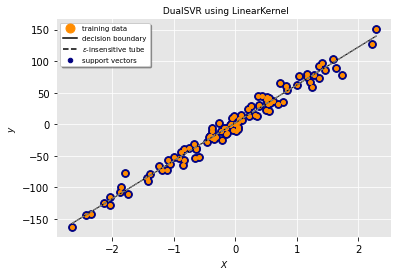

In [15]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [16]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.021536       9  0.917772  0.914479          67        67
           0.2      0.022979       9  0.918341  0.915058          67        67
           0.3      0.019355      10  0.918942  0.915614          66        66
       10  0.1      0.021882       9  0.977920  0.972466          67        67
           0.2      0.013598       9  0.977926  0.972474          67        67
           0.3      0.012306      10  0.977954  0.972562          66        66
       100 0.1      0.012041       9  0.977788  0.974150          67        67
           0.2      0.027912       9  0.977742  0.974033          67        67
           0.3      0.009634       9  0.977737  0.973956          67        67
smo    1   0.1      0.014631      15  0.917773  0.914442          66        66
           0.2      0.014218      13  0.918341  0.915019          66        66
           0.3      0.040505      60  0.918942  0.915576          66        66
       10  0.1      0.063922      56  0.977920  0.972445          66        66
           0.2      0.146936     219  0.977926  0.972457          65        65
           0.3      0.053513      38  0.977953  0.972544          65        65
       100 0.1      0.595028    1508  0.977788  0.974139          66        66
           0.2      0.327064     394  0.977742  0.974022          66        66
           0.3      0.515121     900  0.977737  0.973939          66        66

In [17]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LibSVM]

In [18]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
libsvm 1   0.1      0.002211      63  0.917627  0.915448          66        66
           0.2      0.002491     102  0.918194  0.915985          66        66
           0.3      0.002069      54  0.918786  0.916554          66        66
       10  0.1      0.001865     282  0.977852  0.972051          66        66
           0.2      0.002066     193  0.977851  0.972025          65        65
           0.3      0.002003     593  0.977870  0.972135          65        65
       100 0.1      0.003146    2621  0.977723  0.974270          66        66
           0.2      0.003566    2709  0.977673  0.974122          66        66
           0.3      0.003817    4141  0.977655  0.974045          66        66

In [19]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='h!')
linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.021536       9  0.917772  0.914479          67        67
           0.2      0.022979       9  0.918341  0.915058          67        67
           0.3      0.019355      10  0.918942  0.915614          66        66
       10  0.1      0.021882       9  0.977920  0.972466          67        67
           0.2      0.013598       9  0.977926  0.972474          67        67
           0.3      0.012306      10  0.977954  0.972562          66        66
       100 0.1      0.012041       9  0.977788  0.974150          67        67
           0.2      0.027912       9  0.977742  0.974033          67        67
           0.3      0.009634       9  0.977737  0.973956          67        67
smo    1   0.1      0.014631      15  0.917773  0.914442          66        66
           0.2      0.014218      13  0.918341  0.915019          66        66
           0.3      0.040505      60  0.918942  0.915576          66        66
       10  0.1      0.063922      56  0.977920  0.972445          66        66
           0.2      0.146936     219  0.977926  0.972457          65        65
           0.3      0.053513      38  0.977953  0.972544          65        65
       100 0.1      0.595028    1508  0.977788  0.974139          66        66
           0.2      0.327064     394  0.977742  0.974022          66        66
           0.3      0.515121     900  0.977737  0.973939          66        66
libsvm 1   0.1      0.002211      63  0.917627  0.915448          66        66
           0.2      0.002491     102  0.918194  0.915985          66        66
           0.3      0.002069      54  0.918786  0.916554          66        66
       10  0.1      0.001865     282  0.977852  0.972051          66        66
           0.2      0.002066     193  0.977851  0.972025          65        65
           0.3      0.002003     593  0.977870  0.972135          65        65
       100 0.1      0.003146    2621  0.977723  0.974270          66        66
           0.2      0.003566    2709  0.977673  0.974122          66        66
           0.3      0.003817    4141  0.977655  0.974045          66        66

##### Nonlinear

In [ ]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

In [ ]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [ ]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

In [ ]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

In [ ]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

In [ ]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

In [ ]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='h!')
nonlinear_dual_svr_cv_results

#### Lagrangian Dual

##### Linear

In [20]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [21]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='h!')
linear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
dual C   epsilon                                                            
bcqp 1   0.1      0.656280     522  0.731073  0.721200          67        67
         0.2      0.658018     524  0.731073  0.721199          67        67
         0.3      0.602584     526  0.731073  0.721199          67        67
     10  0.1      0.614027     539  0.733638  0.723925          67        67
         0.2      0.668057     541  0.733638  0.723924          67        67
         0.3      0.637837     543  0.733638  0.723924          67        67
     100 0.1      0.733603     539  0.733638  0.723925          67        67
         0.2      0.627369     541  0.733638  0.723924          67        67
         0.3      0.409460     543  0.733638  0.723924          67        67
qp   1   0.1      0.674449     653  0.876534  0.870926          67        67
         0.2      0.678396     653  0.876534  0.870927          67        67
         0.3      0.722974     653  0.876534  0.870927          67        67
     10  0.1      0.498502     519  0.731825  0.722021          67        67
         0.2      0.563454     524  0.731825  0.722021          67        67
         0.3      0.537692     530  0.731825  0.722020          67        67
     100 0.1      0.652838     519  0.731825  0.722021          67        67
         0.2      0.604621     524  0.731825  0.722021          67        67
         0.3      0.550931     530  0.731825  0.722020          67        67

##### Nonlinear

In [22]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [23]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='h!')
nonlinear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2     val_r2  train_n_sv  \
dual kernel C   epsilon                                                      
bcqp poly   1   0.1      0.482641     345  0.643482 -10.313337          67   
                0.2      0.507596     348  0.632323  -8.680716          67   
                0.3      0.980019     669  0.623699  -7.643487          67   
            10  0.1      0.517057     345  0.643482 -10.313337          67   
                0.2      0.458200     348  0.632323  -8.680716          67   
                0.3      0.920299     669  0.623699  -7.643487          67   
            100 0.1      0.557809     345  0.643482 -10.313337          67   
                0.2      0.492806     348  0.632323  -8.680716          67   
                0.3      0.654942     669  0.623699  -7.643487          67   
     rbf    1   0.1      0.043660      19  0.740194  -1.880483          67   
                0.2      0.192294      92  0.740177  -1.882909          67   
                0.3      0.290547     164  0.603015  -3.956481          67   
            10  0.1      0.037314      19  0.740194  -1.880483          67   
                0.2      0.150209      92  0.740177  -1.882909          67   
                0.3      0.290903     164  0.603015  -3.956481          67   
            100 0.1      0.044858      19  0.740194  -1.880483          67   
                0.2      0.180130      92  0.740177  -1.882909          67   
                0.3      0.264654     164  0.603015  -3.956481          67   
qp   poly   1   0.1      0.471979     347  0.641413 -10.283007          67   
                0.2      0.667717     348  0.633767  -8.692657          67   
                0.3      0.634864     349  0.626387  -7.655867          67   
            10  0.1      0.421276     347  0.641413 -10.283007          67   
                0.2      0.454034     348  0.633767  -8.692657          67   
                0.3      0.492867     349  0.626387  -7.655867          67   
            100 0.1      0.474953     347  0.641413 -10.283007          67   
                0.2      0.574175     348  0.633767  -8.692657          67   
                0.3      0.406300     349  0.626387  -7.655867          67   
     rbf    1   0.1      0.191649     102  0.721454  -2.320027          67   
                0.2      0.407150     157  0.675573  -2.863975          67   
                0.3      0.479133     213  0.627853  -3.010361          67   
            10  0.1      0.128122      42  0.723816  -2.306795          67   
                0.2      0.227605      95  0.675184  -2.866411          67   
                0.3      0.292192     163  0.614802  -3.217847          67   
            100 0.1      0.080129      42  0.723816  -2.306795          67   
                0.2      0.244637      95  0.675184  -2.866411          67   
                0.3      0.393030     163  0.614802  -3.217847          67   

                         val_n_sv  
dual kernel C   epsilon            
bcqp poly   1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
     rbf    1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
qp   poly   1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
     rbf    1   

## Squared Epsilon-insensitive loss

### Primal formulation

In [24]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [25]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


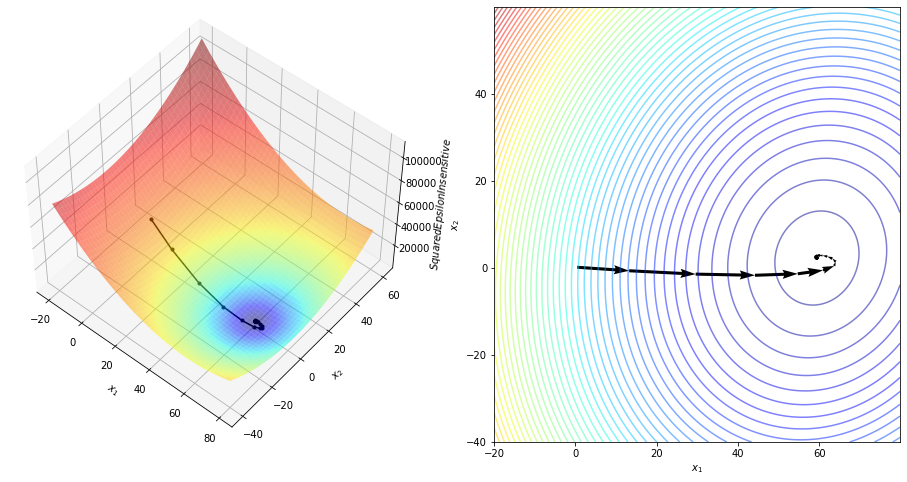

In [26]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, momentum=0.5, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [27]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'gd')
custom_primal_svr_squared_eps_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
custom_primal_svr_squared_eps_cv_results

fit_time  n_iter     train_r2       val_r2  \
solver C   momentum epsilon                                               
gd     1   nesterov 0.1      0.122482     183     0.978130     0.973981   
                    0.2      0.097083     181     0.978129     0.973979   
                    0.3      0.095180     179     0.978129     0.973978   
           none     0.1      0.225937     352     0.978126     0.973976   
                    0.2      0.201861     349     0.978125     0.973973   
                    0.3      0.182420     346     0.978124     0.973972   
           standard 0.1      0.140556     180     0.978130     0.973982   
                    0.2      0.105793     178     0.978129     0.973978   
                    0.3      0.091970     176     0.978129     0.973978   
       10  nesterov 0.1      0.014522      26     0.978184     0.973958   
                    0.2      0.013893      25     0.978184     0.973958   
                    0.3      0.014295      25     0.978184     0.973958   
           none     0.1      0.025880      48     0.978184     0.973958   
                    0.2      0.025119      46     0.978184     0.973957   
                    0.3      0.024273      45     0.978183     0.973955   
           standard 0.1      0.013625      25     0.977874     0.975103   
                    0.2      0.014705      25     0.977870     0.975103   
                    0.3      0.013569      25     0.977870     0.975103   
       100 nesterov 0.1      0.003566       6 -1654.499560 -1623.837989   
                    0.2      0.002298       6 -1652.012027 -1622.203046   
                    0.3      0.002626       6 -1638.526812 -1608.664450   
           none     0.1      0.003628       6   -19.043878   -18.847295   
                    0.2      0.003498       6   -19.096249   -18.942509   
                    0.3      0.003652       6   -18.805534   -18.633600   
           standard 0.1      0.017030      29     0.978184     0.973963   
                    0.2      0.015735      29     0.978184     0.973963   
                    0.3      0.013753      29     0.978184     0.973968   

                             train_n_sv  val_n_sv  
solver C   momentum epsilon                        
gd     1   nesterov 0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
           none     0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
           standard 0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
       10  nesterov 0.1              66        33  
                    0.2              66        33  
                    0.3              66        33  
           none     0.1              66        33  
                    0.2              66        33  
                    0.3              66        32  
           standard 0.1              65        33  
                    0.2              65        33  
                    0.3              65        33  
       100 nesterov 0.1              67        33  
                    0.2              67        33  
                    0.3              67        33  
           none     0.1              67        33  
                    0.2              67        33  
                    0.3              67        33  
           standard 0.1              66        33  
                    0.2              66        33  
                    0.3              66        33

In [28]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [29]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
liblinear 1   -        0.1      0.000834      85  0.978134  0.974007   
                       0.2      0.000932      86  0.978132  0.974007   
                       0.3      0.000998      88  0.978130  0.974014   
          10  -        0.1      0.002740     776  0.978183  0.973961   
                       0.2      0.002714     777  0.978183  0.973968   
                       0.3      0.002906     771  0.978183  0.973985   
          100 -        0.1      0.003736    1000  0.977164  0.972436   
                       0.2      0.002975    1000  0.978023  0.975378   
                       0.3      0.003194    1000  0.977903  0.972687   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
liblinear 1   -        0.1              67        32  
                       0.2              66        32  
                       0.3              66        32  
          10  -        0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
          100 -        0.1              67        32  
                       0.2              66        33  
                       0.3              65        32

In [30]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='h!')
primal_svr_squared_eps_cv_results

fit_time  n_iter     train_r2       val_r2  \
solver    C   momentum epsilon                                               
gd        1   nesterov 0.1      0.122482     183     0.978130     0.973981   
                       0.2      0.097083     181     0.978129     0.973979   
                       0.3      0.095180     179     0.978129     0.973978   
              none     0.1      0.225937     352     0.978126     0.973976   
                       0.2      0.201861     349     0.978125     0.973973   
                       0.3      0.182420     346     0.978124     0.973972   
              standard 0.1      0.140556     180     0.978130     0.973982   
                       0.2      0.105793     178     0.978129     0.973978   
                       0.3      0.091970     176     0.978129     0.973978   
          10  nesterov 0.1      0.014522      26     0.978184     0.973958   
                       0.2      0.013893      25     0.978184     0.973958   
                       0.3      0.014295      25     0.978184     0.973958   
              none     0.1      0.025880      48     0.978184     0.973958   
                       0.2      0.025119      46     0.978184     0.973957   
                       0.3      0.024273      45     0.978183     0.973955   
              standard 0.1      0.013625      25     0.977874     0.975103   
                       0.2      0.014705      25     0.977870     0.975103   
                       0.3      0.013569      25     0.977870     0.975103   
          100 nesterov 0.1      0.003566       6 -1654.499560 -1623.837989   
                       0.2      0.002298       6 -1652.012027 -1622.203046   
                       0.3      0.002626       6 -1638.526812 -1608.664450   
              none     0.1      0.003628       6   -19.043878   -18.847295   
                       0.2      0.003498       6   -19.096249   -18.942509   
                       0.3      0.003652       6   -18.805534   -18.633600   
              standard 0.1      0.017030      29     0.978184     0.973963   
                       0.2      0.015735      29     0.978184     0.973963   
                       0.3      0.013753      29     0.978184     0.973968   
liblinear 1   -        0.1      0.000834      85     0.978134     0.974007   
                       0.2      0.000932      86     0.978132     0.974007   
                       0.3      0.000998      88     0.978130     0.974014   
          10  -        0.1      0.002740     776     0.978183     0.973961   
                       0.2      0.002714     777     0.978183     0.973968   
                       0.3      0.002906     771     0.978183     0.973985   
          100 -        0.1      0.003736    1000     0.977164     0.972436   
                       0.2      0.002975    1000     0.978023     0.975378   
                       0.3      0.003194    1000     0.977903     0.972687   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
gd        1   nesterov 0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
              none     0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
              standard 0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
          10  nesterov 0.1              66        33  
                       0.2              66        33  
                       0.3              66        33  
              none     0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
              standard 0.1              65        33  
                       0.2              65        33  
                      